In [5]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

df_unfiltered = pd.read_csv('data/stations_data.csv')
territory_df = pd.read_excel('data/SDGE_territory.xlsx')
columns_to_keep = ['access_code', 'access_days_time', 'cards_accepted', 'expected_date', 'fuel_type_code', 'id','maximum_vehicle_class', 'open_date', 'owner_type_code',
'restricted_access', 'status_code', 'funding_sources', 'facility_type','station_name',
'latitude', 'longitude', 'city', 'country', 'intersection_directions','state', 'street_address', 'zip']
df = df_unfiltered[columns_to_keep]
#only keep stations in SDGE territory
sdge_df = df.merge(territory_df, left_on = 'zip', right_on = 'ZIP_CODE')

## **OSMnx**
**Visualize Path**

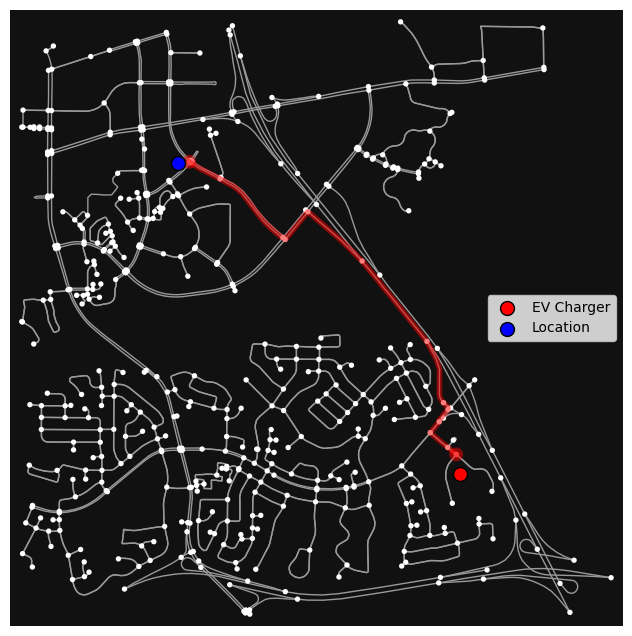

In [6]:
ev_charger = (32.853080, -117.18448)  
home = (32.8719468, -117.204839)  

center_point = ((ev_charger[0] + home[0]) / 2, (ev_charger[1] + home[1]) / 2)
G = ox.graph_from_point(center_point, dist=2000, network_type='drive')

home_node = ox.distance.nearest_nodes(G, home[1], home[0])
ev_charger_node = ox.distance.nearest_nodes(G, ev_charger[1], ev_charger[0])

route = ox.shortest_path(G, home_node, ev_charger_node, weight='length')

fig, ax = ox.plot_graph_route(G, route, show=False, close=False)

ax.scatter(ev_charger[1], ev_charger[0], c='red', s=100, label='EV Charger', edgecolor='black')
ax.scatter(home[1], home[0], c='blue', s=100, label='Location', edgecolor='black')

ax.legend()
plt.show()


**Path Distance Calculation**

In [7]:
home = (32.8719468,-117.204839)

# Download a graph that includes your home and nearby EV chargers
center_point = home
G = ox.graph_from_point(center_point, dist=5000, network_type='drive')

# Find the nearest node to your home
home_node = ox.distance.nearest_nodes(G, home[1], home[0])

# Find the nearest node to a specific charger (just one example here)
charger = (32.853080, -117.18448)  # Example charger coordinates
charger_node = ox.distance.nearest_nodes(G, charger[1], charger[0])

# Calculate the shortest path and distance between the home and the charger
try:
    route = ox.shortest_path(G, home_node, charger_node, weight='length')
    distance = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    print(f"Shortest driving distance: {distance / 1000:.2f} km")
except nx.NetworkXNoPath:
    print("No path found between the points.")


Shortest driving distance: 3.20 km


**Find cloesest charger given location**

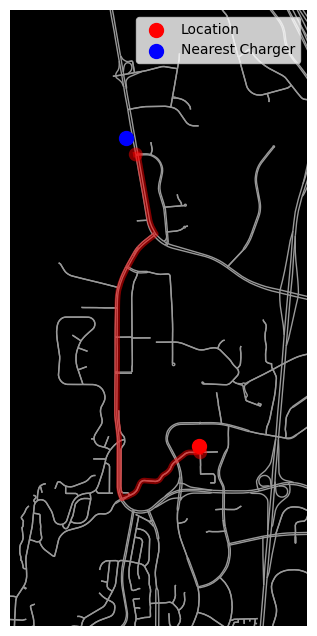

In [8]:
home = (32.8752647,-117.236133)

chargers = list(zip(sdge_df['latitude'],sdge_df['longitude']))[:10]

center_point = home 
G = ox.graph_from_point(center_point, dist=20000, network_type='drive')

home_node = ox.distance.nearest_nodes(G, home[1], home[0])

nearest_nodes = [ox.distance.nearest_nodes(G, charger[1], charger[0]) for charger in chargers]

shortest_distance = float('inf')
nearest_charger_node = None
nearest_charger_index = None
shortest_route = None

for idx, charger_node in enumerate(nearest_nodes):
    try:
        route = nx.shortest_path(G, home_node, charger_node, weight='length')
        distance = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    
        if distance < shortest_distance:
            shortest_distance = distance
            nearest_charger_node = charger_node
            nearest_charger_index = idx
            shortest_route = route
    except nx.NetworkXNoPath:
        continue

import matplotlib.pyplot as plt

fig, ax = ox.plot_graph_route(G, shortest_route, route_linewidth=4, node_size=0, bgcolor='k',
                              show=False, close=False)

home_lat, home_lon = home
ax.scatter(home_lon, home_lat, c='red', s=100, label='Location', zorder=5)

charger_lat, charger_lon = chargers[nearest_charger_index]
ax.scatter(charger_lon, charger_lat, c='blue', s=100, label='Nearest Charger', zorder=5)

route_nodes = [G.nodes[node] for node in shortest_route]
route_lats = [node['y'] for node in route_nodes]
route_lons = [node['x'] for node in route_nodes]

margin = 0.01 
min_lat, max_lat = min(route_lats + [home_lat, charger_lat]) - margin, max(route_lats + [home_lat, charger_lat]) + margin
min_lon, max_lon = min(route_lons + [home_lon, charger_lon]) - margin, max(route_lons + [home_lon, charger_lon]) + margin

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

plt.legend()
plt.show()


## **Cenpy**

In [9]:
import cenpy
conn = cenpy.products.APIConnection("ACSDT5Y2022")
cenpy_data = conn.query(["B19013_001E","B15003_001E","B15003_017E","B15003_022E"], geo_unit = 'zip code tabulation area')
cenpy_data = cenpy_data.rename(columns={'B19013_001E': 'income','zip code tabulation area': 'zip', 'B15003_001E': 'total_population',"B15003_017E": 'population_bachelor','B15003_022E': 'population_advanced'})
cenpy_data['zip'] = cenpy_data['zip'].astype(int)
cenpy_data['income'] = cenpy_data['income'].astype(int)
cenpy_data['total_population'] = cenpy_data['total_population'].astype(int)
cenpy_data['population_bachelor'] = cenpy_data['population_bachelor'].astype(int)
cenpy_data['population_advanced'] = cenpy_data['population_advanced'].astype(int)
cenpy_data = cenpy_data[cenpy_data['income'] > 0]



In [3]:
merged_df = sdge_df.merge(cenpy_data,left_on = 'ZIP_CODE', right_on = 'zip')
total_population = merged_df.groupby('city').sum()['total_population']
population = merged_df.groupby('city').sum()['total_population']

In [4]:
temp_df = pd.DataFrame(sdge_df.groupby('zip').count()['access_code'])
merged_df2 = temp_df.merge(cenpy_data,left_index = True, right_on = 'zip')
merged_df2 = merged_df2.rename(columns={'access_code': 'count'})

**Distribution of Median Household Income, Total Population, and Population with Advanced Degrees**

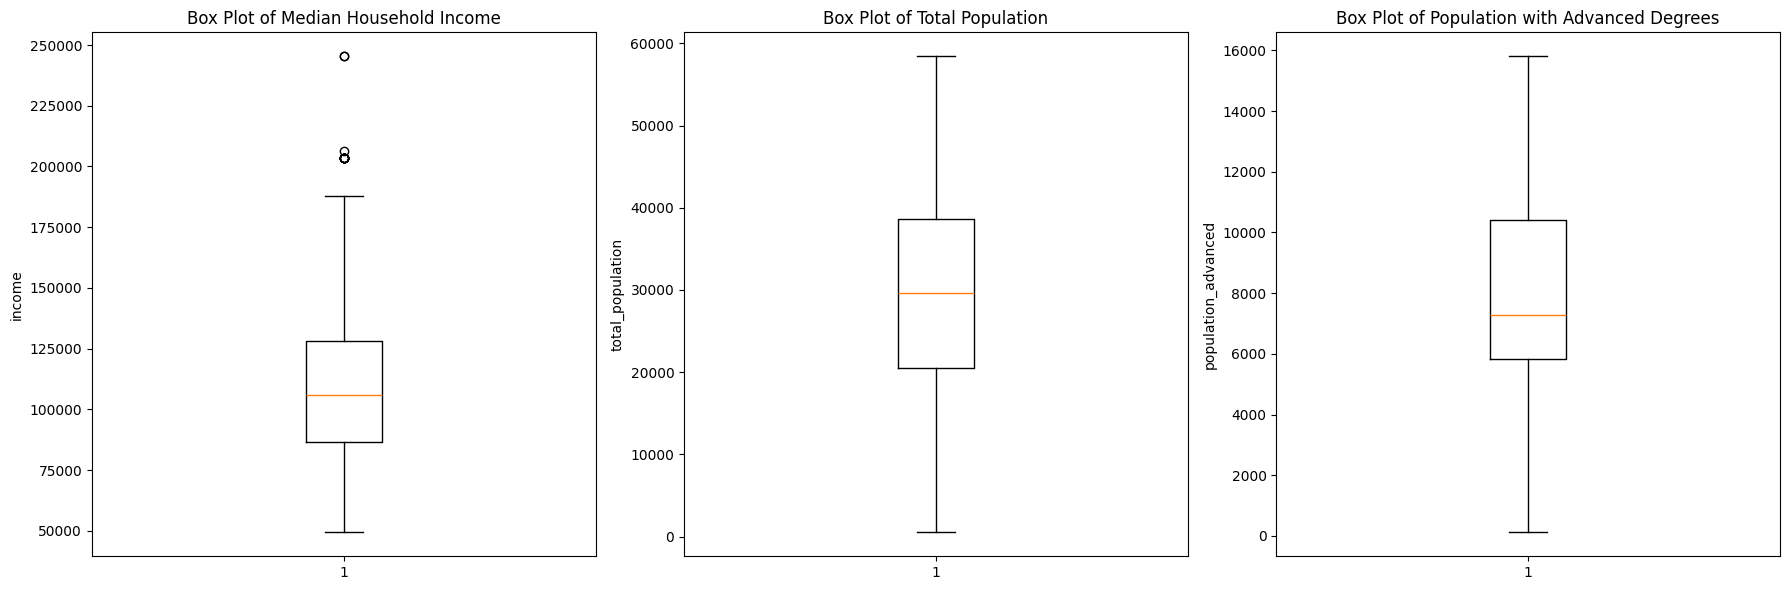

In [16]:
import matplotlib.pyplot as plt

variables = ['income', 'total_population', 'population_advanced']
titles = ['Median Household Income', 'Total Population', 'Population with Advanced Degrees']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, var in enumerate(variables):
    axes[i].boxplot(merged_df[var])
    axes[i].set_title(f'Box Plot of {titles[i]}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

**Scatter Plot of Income vs Variables**

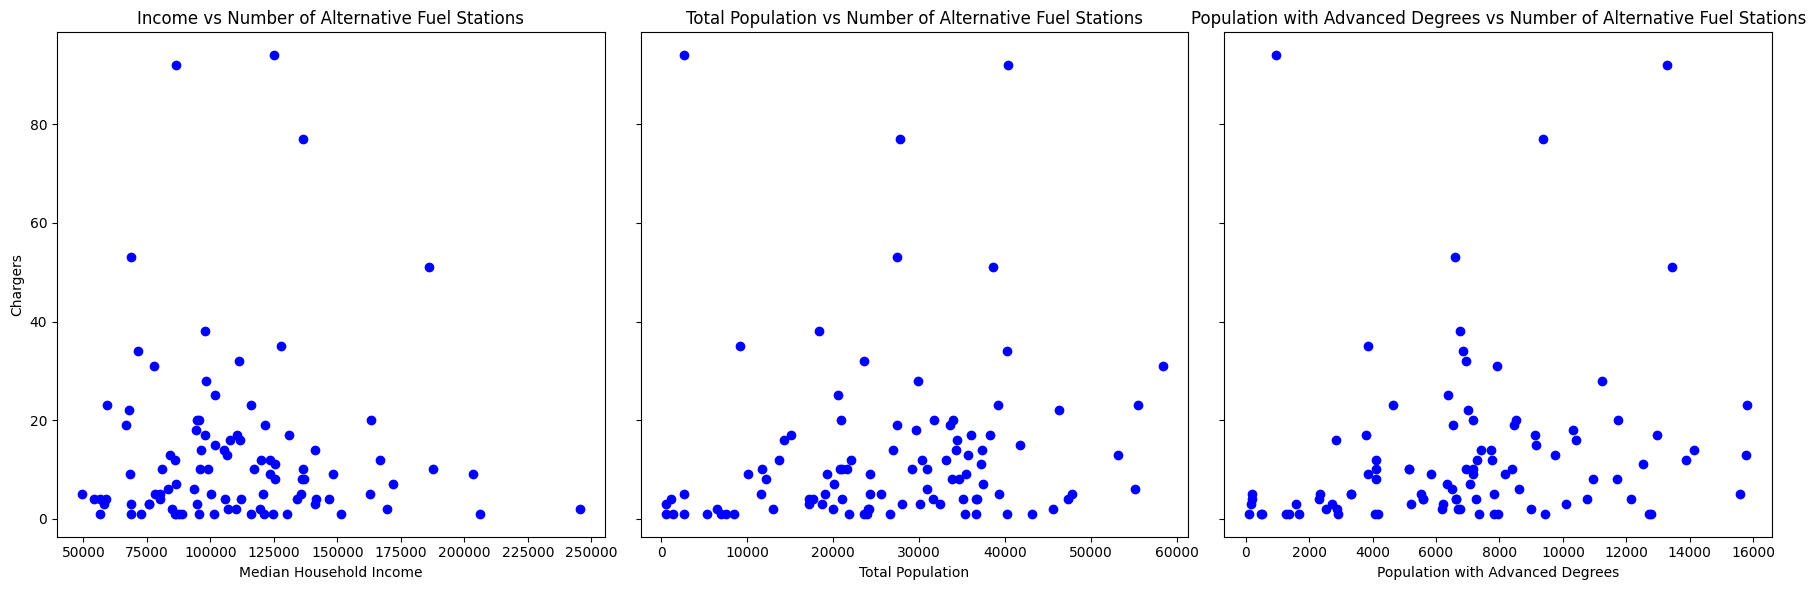

In [10]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Scatter plot 1: Income vs number of alternative fuel stations
axes[0].scatter(merged_df2['income'], merged_df2['count'], c='blue')
axes[0].set_title('Income vs Number of Alternative Fuel Stations')
axes[0].set_xlabel('Median Household Income')
axes[0].set_ylabel('Chargers')

# Scatter plot 2: Total population vs number of alternative fuel stations
axes[1].scatter(merged_df2['total_population'], merged_df2['count'], c='blue')
axes[1].set_title('Total Population vs Number of Alternative Fuel Stations')
axes[1].set_xlabel('Total Population')

# Scatter plot 3: Population advanced vs number of alternative fuel stations
axes[2].scatter(merged_df2['population_advanced'], merged_df2['count'], c='blue')
axes[2].set_title('Population with Advanced Degrees vs Number of Alternative Fuel Stations')
axes[2].set_xlabel('Population with Advanced Degrees')

# Adjust layout
plt.tight_layout()
plt.show()
